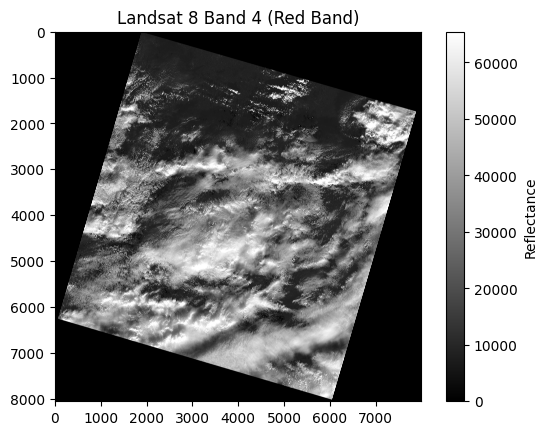

In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load the Landsat 8 Band 4 image
image_path = "data/LC08_L2SP_196024_20241117_20241126_02_T2_SR_B4.TIF"
with rasterio.open(image_path) as src:
    image = src.read(1)  # Read the first band (Red Band)
    metadata = src.meta  # Metadata (e.g., CRS, transform)

# Visualize the image
plt.imshow(image, cmap='gray')
plt.title("Landsat 8 Band 4 (Red Band)")
plt.colorbar(label="Reflectance")
plt.show()

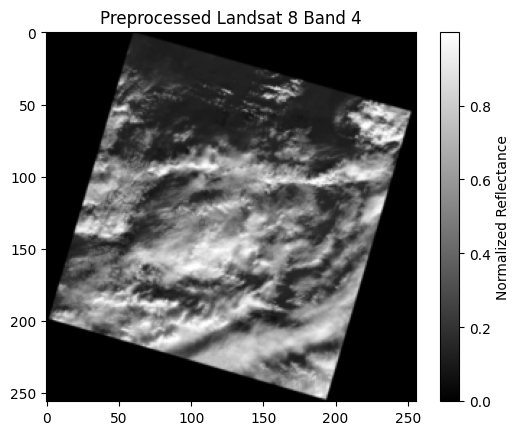

In [9]:
from skimage.transform import resize

# Normalize the image to [0, 1]
image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image))

# Resize the image (optional)
image_resized = resize(image_normalized, (256, 256), anti_aliasing=True)

# Visualize the preprocessed image
plt.imshow(image_resized, cmap='gray')
plt.title("Preprocessed Landsat 8 Band 4")
plt.colorbar(label="Normalized Reflectance")
plt.show()

In [ ]:
import torch
import torch.nn as nn

class UNetISP(nn.Module):
    def __init__(self):
        super(UNetISP, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the U-Net model
isp_model = UNetISP()
print(isp_model)

UNetISP(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


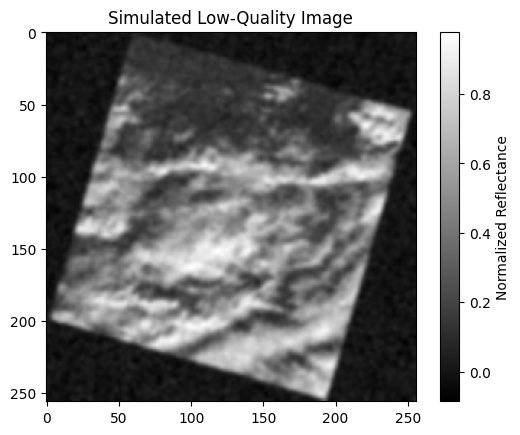

In [11]:
# Convert the image to a PyTorch tensor
image_tensor = torch.tensor(image_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]

# Simulate a low-quality version (e.g., add noise and downsample)
import torch.nn.functional as F

# Add Gaussian noise
noise = torch.randn_like(image_tensor) * 0.1
low_quality_image = image_tensor + noise

# Add blur (simulate out-of-focus degradation)
low_quality_image = low_quality_image.squeeze().numpy()  # Convert to NumPy for OpenCV
low_quality_image = cv2.GaussianBlur(low_quality_image, (5, 5), 0)
low_quality_image = torch.tensor(low_quality_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Downsample the image
low_quality_image = F.interpolate(low_quality_image, scale_factor=0.5, mode='bilinear', align_corners=False)
low_quality_image = F.interpolate(low_quality_image, scale_factor=2.0, mode='bilinear', align_corners=False)  # Upsample back to original size

# Visualize the low-quality image
plt.imshow(low_quality_image.squeeze().numpy(), cmap='gray')
plt.title("Simulated Low-Quality Image")
plt.colorbar(label="Normalized Reflectance")
plt.show()

In [21]:
pip install --upgrade torch torchvision

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from torchmetrics import StructuralSimilarityIndexMeasure
from torchvision.models import vgg16_bn  # Use VGG16 with batch normalization

# Initialize SSIM loss
ssim_loss = StructuralSimilarityIndexMeasure(data_range=1.0)

# Load a pre-trained VGG16 model for perceptual loss
vgg_model = vgg16_bn(pretrained=True).features[:16]  # Use the first 16 layers
vgg_model = vgg_model.eval()  # Set to evaluation mode

# Define perceptual loss
def perceptual_loss(output, target):
    # Extract features from VGG16
    output_features = vgg_model(output)
    target_features = vgg_model(target)
    # Compute MSE between features
    return F.mse_loss(output_features, target_features)

# Combine SSIM loss and perceptual loss
def combined_loss(output, target):
    ssim = ssim_loss(output, target)
    perceptual = perceptual_loss(output, target)
    return (1 - ssim) + perceptual  # Minimize both losses

In [14]:
# Convert the 1-channel grayscale image to 3 channels
image_tensor_3ch = image_tensor.repeat(1, 3, 1, 1)  # Shape: [1, 3, H, W]
low_quality_image_3ch = low_quality_image.repeat(1, 3, 1, 1)  # Shape: [1, 3, H, W]

# Define perceptual loss
def perceptual_loss(output, target):
    # Convert output and target to 3 channels
    output_3ch = output.repeat(1, 3, 1, 1)  # Shape: [1, 3, H, W]
    target_3ch = target.repeat(1, 3, 1, 1)  # Shape: [1, 3, H, W]
    
    # Extract features from VGG16
    output_features = vgg_model(output_3ch)
    target_features = vgg_model(target_3ch)
    
    # Compute MSE between features
    return F.mse_loss(output_features, target_features)

# Combine SSIM loss and perceptual loss
def combined_loss(output, target):
    ssim = ssim_loss(output, target)
    perceptual = perceptual_loss(output, target)
    return (1 - ssim) + perceptual  # Minimize both losses

# Training loop
for epoch in range(200):  # Train for 200 epochs
    optimizer.zero_grad()
    output = isp_model(low_quality_image)
    loss = combined_loss(output, image_tensor)  # Use combined loss
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 1.003239393234253
Epoch 2, Loss: 0.9297839403152466
Epoch 3, Loss: 0.6731901168823242
Epoch 4, Loss: 0.815521240234375
Epoch 5, Loss: 0.7658040523529053
Epoch 6, Loss: 0.6062790751457214
Epoch 7, Loss: 0.6967164874076843
Epoch 8, Loss: 0.6705645322799683
Epoch 9, Loss: 0.554989218711853
Epoch 10, Loss: 0.5742602348327637
Epoch 11, Loss: 0.5957326889038086
Epoch 12, Loss: 0.5338383913040161
Epoch 13, Loss: 0.48093682527542114
Epoch 14, Loss: 0.43568968772888184
Epoch 15, Loss: 0.31121379137039185
Epoch 16, Loss: 0.3100739121437073
Epoch 17, Loss: 0.2455909550189972
Epoch 18, Loss: 0.24297945201396942
Epoch 19, Loss: 0.24734768271446228
Epoch 20, Loss: 0.18472856283187866
Epoch 21, Loss: 0.19689691066741943
Epoch 22, Loss: 0.2217109650373459
Epoch 23, Loss: 0.16668379306793213
Epoch 24, Loss: 0.1620829850435257
Epoch 25, Loss: 0.17938008904457092
Epoch 26, Loss: 0.1631462424993515
Epoch 27, Loss: 0.14607131481170654
Epoch 28, Loss: 0.1613258421421051
Epoch 29, Loss: 0.1599

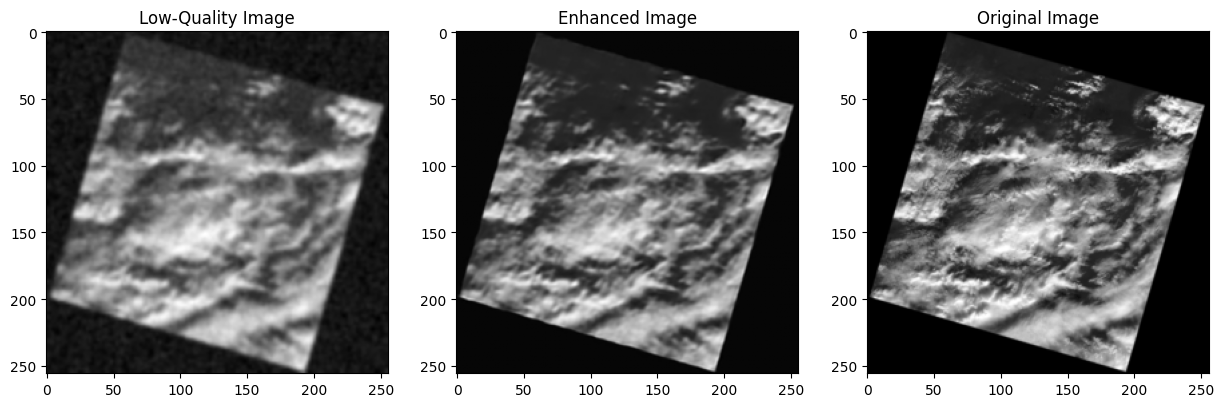

In [15]:
# Enhance the low-quality image
enhanced_image = isp_model(low_quality_image)

# Visualize the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(low_quality_image.squeeze().numpy(), cmap='gray')
plt.title("Low-Quality Image")
plt.subplot(1, 3, 2)
plt.imshow(enhanced_image.squeeze().detach().numpy(), cmap='gray')  # Squeeze to remove the batch dimension
plt.title("Enhanced Image")
plt.subplot(1, 3, 3)
plt.imshow(image_tensor.squeeze().numpy(), cmap='gray')
plt.title("Original Image")
plt.show()

In [16]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Convert images to NumPy arrays
original_image_np = image_tensor.squeeze().numpy()
enhanced_image_np = enhanced_image.squeeze().detach().numpy()
low_quality_image_np = low_quality_image.squeeze().numpy()

# Calculate PSNR
psnr_original_vs_enhanced = psnr(original_image_np, enhanced_image_np, data_range=1.0)
psnr_original_vs_low_quality = psnr(original_image_np, low_quality_image_np, data_range=1.0)

# Calculate SSIM
ssim_original_vs_enhanced = ssim(original_image_np, enhanced_image_np, data_range=1.0)
ssim_original_vs_low_quality = ssim(original_image_np, low_quality_image_np, data_range=1.0)

# Calculate MSE
mse_original_vs_enhanced = np.mean((original_image_np - enhanced_image_np) ** 2)
mse_original_vs_low_quality = np.mean((original_image_np - low_quality_image_np) ** 2)

# Print the results
print("PSNR (Original vs Enhanced):", psnr_original_vs_enhanced)
print("PSNR (Original vs Low-Quality):", psnr_original_vs_low_quality)
print("SSIM (Original vs Enhanced):", ssim_original_vs_enhanced)
print("SSIM (Original vs Low-Quality):", ssim_original_vs_low_quality)
print("MSE (Original vs Enhanced):", mse_original_vs_enhanced)
print("MSE (Original vs Low-Quality):", mse_original_vs_low_quality)

PSNR (Original vs Enhanced): 28.386510251466884
PSNR (Original vs Low-Quality): 26.019912511307357
SSIM (Original vs Enhanced): 0.9231414427068233
SSIM (Original vs Low-Quality): 0.7101417992984019
MSE (Original vs Enhanced): 0.0014499365
MSE (Original vs Low-Quality): 0.0025003958


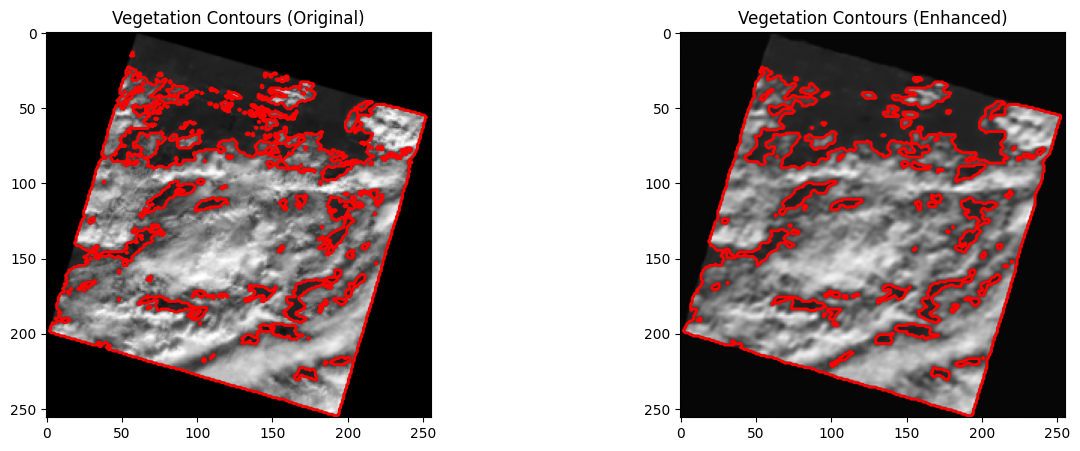

In [17]:
from skimage import measure

# Thresholding to extract vegetation (adjust threshold as needed)
vegetation_threshold = 0.2
vegetation_mask_original = original_image_np < vegetation_threshold
vegetation_mask_enhanced = enhanced_image_np < vegetation_threshold

# Extract contours of vegetation
contours_original = measure.find_contours(vegetation_mask_original, 0.5)
contours_enhanced = measure.find_contours(vegetation_mask_enhanced, 0.5)

# Visualize vegetation contours on original and enhanced images
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image_np, cmap='gray')
for contour in contours_original:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
plt.title("Vegetation Contours (Original)")
plt.subplot(1, 2, 2)
plt.imshow(enhanced_image_np, cmap='gray')
for contour in contours_enhanced:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
plt.title("Vegetation Contours (Enhanced)")
plt.show()

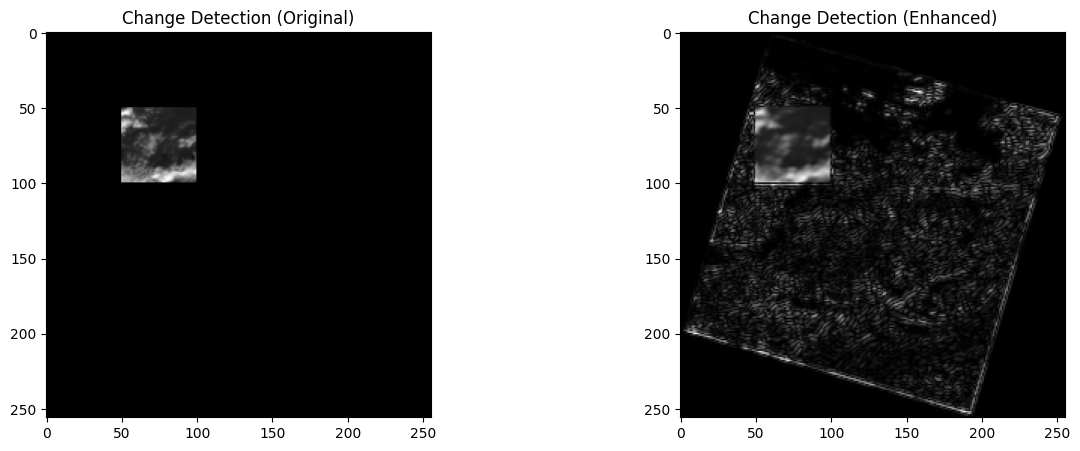

In [19]:
# Simulate a change (e.g., deforestation) by adding a synthetic patch
changed_image = original_image_np.copy()
changed_image[50:100, 50:100] = 0  # Simulate a black patch (e.g., deforestation)

# Enhance the changed image
changed_image_tensor = torch.tensor(changed_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
enhanced_changed_image = isp_model(changed_image_tensor).squeeze().detach().numpy()

# Compute difference maps
difference_original = np.abs(original_image_np - changed_image)
difference_enhanced = np.abs(enhanced_image_np - enhanced_changed_image)

# Visualize difference maps
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(difference_original, cmap='gray')
plt.title("Change Detection (Original)")
plt.subplot(1, 2, 2)
plt.imshow(difference_enhanced, cmap='gray')
plt.title("Change Detection (Enhanced)")
plt.show()

Noise Level (Original): 0.010513000778924395
Noise Level (Enhanced): 0.0011150529074803626


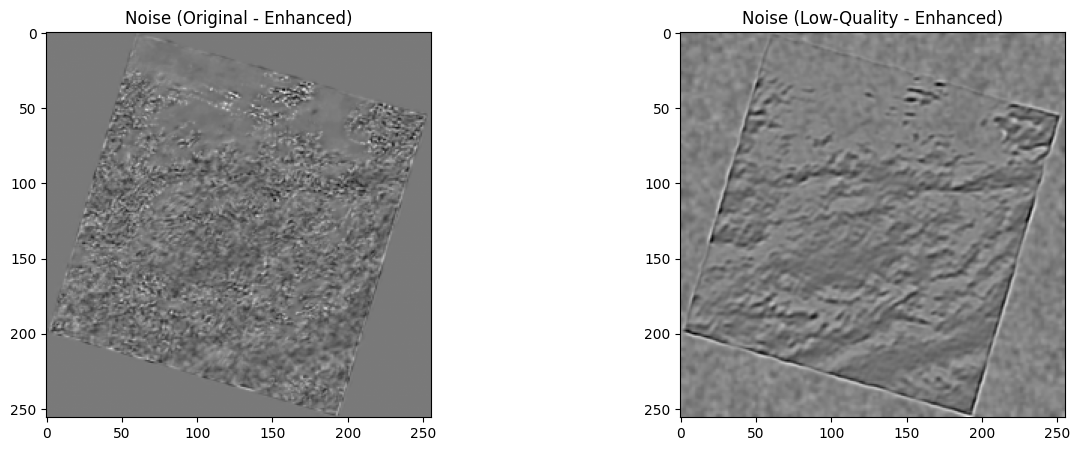

In [22]:
from skimage.restoration import estimate_sigma

# Estimate noise levels
noise_original = estimate_sigma(original_image_np)
noise_enhanced = estimate_sigma(enhanced_image_np)

print("Noise Level (Original):", noise_original)
print("Noise Level (Enhanced):", noise_enhanced)

# Visualize noise
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image_np - enhanced_image_np, cmap='gray')
plt.title("Noise (Original - Enhanced)")
plt.subplot(1, 2, 2)
plt.imshow(low_quality_image_np - enhanced_image_np, cmap='gray')
plt.title("Noise (Low-Quality - Enhanced)")
plt.show()